In [1]:
import torch                                                                    
import torchvision                                                              
import torchvision.transforms as transforms    
import numpy as np
import random

In [2]:
torch.cuda.is_available()

True

# Dataset

In [3]:
from torchvision import datasets                                                # Access to benchmarking datasets

train_set = datasets.MNIST('./data_MNIST', train=True, download=True,                 # Downloading the training dataset in ./data folder
                    transform=transforms.Compose([                              # and transforming the images to tensors and normalizing with
                        transforms.ToTensor(),                                  # mean and std of the entire dataset
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

test_set = datasets.MNIST('./data_MNIST', train=False, download=True,                 # Downloading the test dataset in ./data folder 
                    transform=transforms.Compose([                              # and transforming the images to tensors and normalizing with
                        transforms.ToTensor(),                                  # mean and std of the entire dataset
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

In [4]:
def num_to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

def categorical_to_num(y):
  """ Decodes a 1-hot encoding """
  return np.argmax(y)

In [5]:

# Dataset is there to be able to interact with DataLoader
from torch.utils.data import Dataset                                            

class mnist_data(Dataset):
  '''
  mnist_data class to create an iteratable on our custom mnist dataset:
  where data = (image and number label as one-hot-encoding) and labels = (image)

  Attributes:
    mnist: mnist data object
  Methods:
    len: returns length of the dataset 
    getitem: custom getitem method returns data and labels
  '''

  def __init__(self, d):
    self.mnist = d                                                              # Initialize with mnist data object
    
  def __getitem__(self, index):
                                                     
    image, label = self.mnist[index]   
    number_encoding = num_to_categorical(label, 10)                             # 1-hot encoding of number 
    number_encoding = torch.tensor(number_encoding)

    return (image.flatten(), number_encoding), image                                     # (input), (output) to network      

  def __len__(self):                                                            # Return the length of the dataset
    return len(self.mnist)

In [6]:
train_set_custom = mnist_data(train_set)                                        # custom train_set from mnist_data class
test_set_custom = mnist_data(test_set)                                          # custom test_set from mnist_data class

In [7]:
use_cuda = torch.cuda.is_available()                                            # use gpu if available
device = torch.device("cuda" if use_cuda else "cpu")                            # assigning gpu to variable device

# If you load your samples in the Dataset on CPU and would like to push it during training to the GPU, 
# you can speed up the host to device transfer by enabling pin_memory.
# num_workers attribute tells the data loader instance how many sub-processes to use for data loading
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}             
batch_size = 100                                                                # set size of batch                                    

train_loader = torch.utils.data.DataLoader(                                     # For iterating through our dataset in batches      
    train_set_custom,
    batch_size = batch_size,  
    shuffle=True,                                                               # Shuffle the data points randomly
    **kwargs
)

test_loader = torch.utils.data.DataLoader(
    test_set_custom,
    batch_size = batch_size,
    shuffle=True, 
    **kwargs
)

# Network
Reference: https://avandekleut.github.io/vae/

In [8]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import matplotlib.pyplot as plt
import torch.optim as optim


In [9]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x, num):
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)

        ## Adding the one-hot encoding of the number 
        z = z+num                                    

        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [11]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x1, x2):
        z = self.encoder(x1, x2)
        return self.decoder(z)

In [12]:
latent_dims = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = VariationalAutoencoder(latent_dims).to(device) 

In [13]:
train_losses = []
test_losses = []

def train_vae(model, train_data, test_data, epochs=20):
    opt = torch.optim.Adam(model.parameters())
    for epoch in range(epochs):

        model.train()
        for x, y in train_data:
            x1, x2 = x
            x1 = x1.to(device) # GPU
            x2 = x2.to(device) # GPU
            y = y.to(device) # GPU
            opt.zero_grad()
            x_hat = model(x1, x2)
            train_loss = ((y - x_hat)**2).sum() + model.encoder.kl
            train_loss.backward()
            opt.step()

        model.eval()
        test_loss_sum = 0 
        c = 0
        for x, y in test_data:
            x1, x2 = x
            x1 = x1.to(device) # GPU
            x2 = x2.to(device) # GPU
            y = y.to(device) # GPU
            x_hat = model(x1, x2)
            test_loss = ((y - x_hat)**2).sum() + model.encoder.kl
            test_loss_sum += test_loss
            c += 1

        test_loss_avg = test_loss_sum/c
        print(f'Epoch {epoch}. Train loss: {train_loss}, Test loss: {test_loss_avg}')

        train_losses.append(train_loss)
        test_losses.append(test_loss_avg)
        
    return model

model = train_vae(model, train_loader, test_loader, 50)


Epoch 0. Train loss: 46835.21875, Test loss: 47392.55078125
Epoch 1. Train loss: 45842.37890625, Test loss: 46401.3984375
Epoch 2. Train loss: 44780.7578125, Test loss: 46007.71484375
Epoch 3. Train loss: 45299.66796875, Test loss: 45721.17578125
Epoch 4. Train loss: 44095.6328125, Test loss: 45606.30859375
Epoch 5. Train loss: 45889.7578125, Test loss: 45421.48828125
Epoch 6. Train loss: 43319.3671875, Test loss: 45308.66796875
Epoch 7. Train loss: 44938.4140625, Test loss: 45246.3125
Epoch 8. Train loss: 45644.4609375, Test loss: 45193.4140625
Epoch 9. Train loss: 44524.53125, Test loss: 45102.11328125
Epoch 10. Train loss: 46087.0234375, Test loss: 45059.015625
Epoch 11. Train loss: 44166.7109375, Test loss: 44995.22265625
Epoch 12. Train loss: 44479.73828125, Test loss: 44975.64453125
Epoch 13. Train loss: 43565.83203125, Test loss: 44958.48046875
Epoch 14. Train loss: 44673.1875, Test loss: 44857.7578125
Epoch 15. Train loss: 44292.24609375, Test loss: 44903.703125
Epoch 16. Train

In [15]:
torch.save(model.state_dict(), 'results/MNIST.pth')

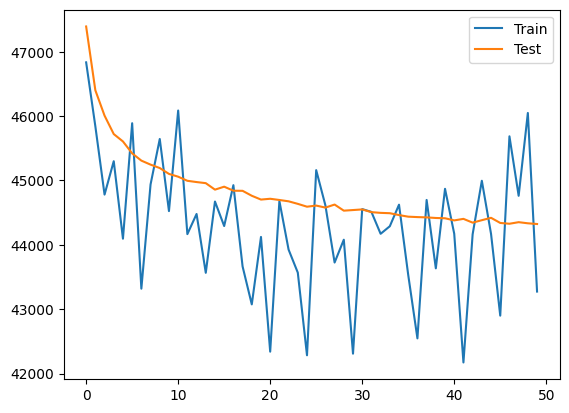

In [14]:
train_losses = [t.detach().cpu() for t in train_losses]
test_losses = [t.detach().cpu() for t in test_losses]

plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.legend()
plt.show()

# Prediction: Image with wrong number

In [23]:
count = 0 
all_predictions_wrong = []
all_predictions_correct = []
all_labels = []

for data, label in test_loader:

    r_idx = random.randrange(0, batch_size)

    input1 = data[0][r_idx]
    input2 = data[1][r_idx]
    gt = label[r_idx]

    correct_label = categorical_to_num(np.array(input2))

    while count < 25: 
        r_label = random.randrange(0, 10)
        if r_label != correct_label:
            wrong_label = r_label

            all_labels.append([correct_label, wrong_label])

            wrong_label_vector = num_to_categorical(wrong_label, 10)
            input2_mod = input2.clone()
            input2_mod = torch.tensor(wrong_label_vector)


            ## unqueeze to get batch dim
            input1 = input1.unsqueeze(0)  
            input2 = input2.unsqueeze(0)

            input2_mod = input2_mod.unsqueeze(0) 
            gt = gt.unsqueeze(0)

            # print(f'gt label {correct_label}, wrong label added {wrong_label}')

            prediction_correct = model(input1.to(device), input2.to(device)).detach().cpu().squeeze(0).squeeze(0)
            prediction_wrong = model(input1.to(device), input2_mod.to(device)).detach().cpu().squeeze(0).squeeze(0)

            all_predictions_correct.append(prediction_correct)
            all_predictions_wrong.append(prediction_wrong)

            count += 1 

    break

In [24]:
def plot_grid(image, labels, noise=False):

    nrows = 5
    ncols = 5

    fig, ax = plt.subplots(nrows, ncols, figsize=(10, 10))

    for i in range(nrows):
        for j in range(ncols):
            index = i * ncols + j
            ax[i, j].axis("off")
            ax[i, j].imshow(image[index])

            correct, wrong = labels[index]
            if noise: 
                s = f'True: {correct}\nNoise: {wrong}'
                ax[i, j].text(0, 5, s, color='Orange')
            else: 
                s = f'True: {correct}'                
                ax[i, j].text(0, 2, s, color='Orange')
            

            
    plt.subplots_adjust(wspace=0, hspace=0.01)


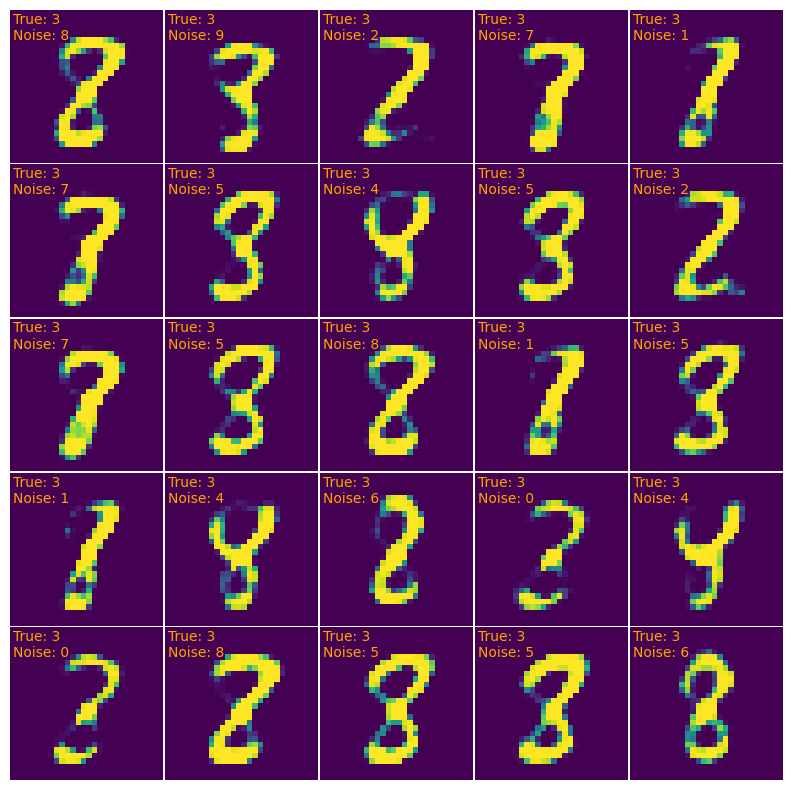

In [25]:
plot_grid(all_predictions_wrong, all_labels, True)

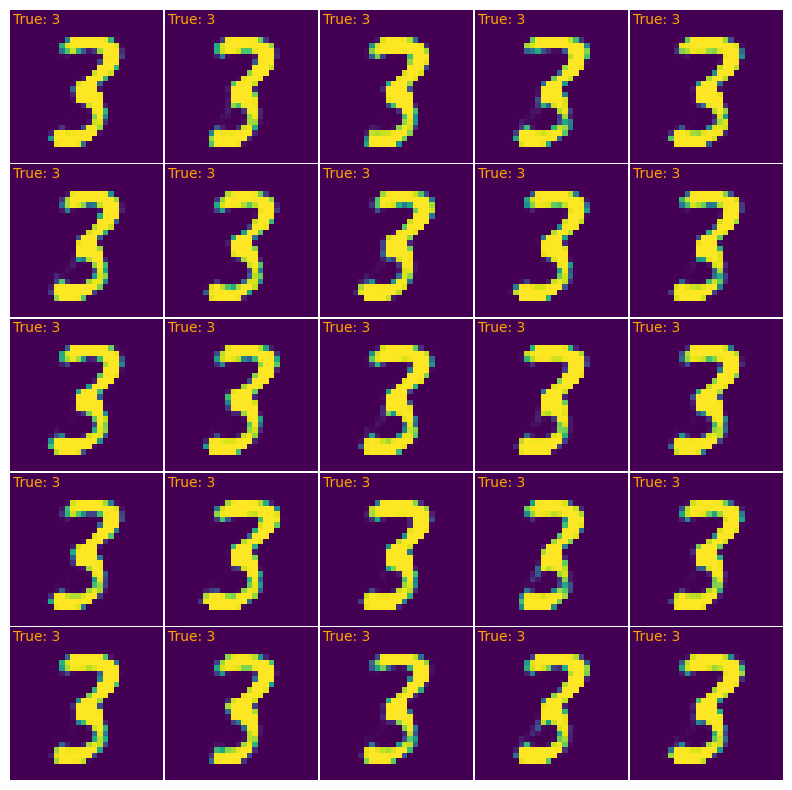

: 

In [26]:
plot_grid(all_predictions_correct, all_labels, False)